
<font size = "13"><span style="color:#EFE1D1">
✍(◔◡◔) Machine Learning wiith Pyspark LinearSVC
</span></font>

In [173]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler, OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [174]:
spark = SparkSession.builder.getOrCreate()


<font size = "13"><span style="color:#EFE1D1">
(☞ﾟヮﾟ)☞ Simple EDA
</span></font>

In [175]:
spark_data_raw = spark.read.csv('Customer_Behaviour.csv', header=True, inferSchema=True)
spark_data_raw.show()

+--------+------+---+---------------+---------+
| User ID|Gender|Age|EstimatedSalary|Purchased|
+--------+------+---+---------------+---------+
|15624510|  Male| 19|          19000|        0|
|15810944|  Male| 35|          20000|        0|
|15668575|Female| 26|          43000|        0|
|15603246|Female| 27|          57000|        0|
|15804002|  Male| 19|          76000|        0|
|15728773|  Male| 27|          58000|        0|
|15598044|Female| 27|          84000|        0|
|15694829|Female| 32|         150000|        1|
|15600575|  Male| 25|          33000|        0|
|15727311|Female| 35|          65000|        0|
|15570769|Female| 26|          80000|        0|
|15606274|Female| 26|          52000|        0|
|15746139|  Male| 20|          86000|        0|
|15704987|  Male| 32|          18000|        0|
|15628972|  Male| 18|          82000|        0|
|15697686|  Male| 29|          80000|        0|
|15733883|  Male| 47|          25000|        1|
|15617482|  Male| 45|          26000|   

In [176]:
spark_data_raw.printSchema()

root
 |-- User ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- EstimatedSalary: integer (nullable = true)
 |-- Purchased: integer (nullable = true)



In [177]:
data_agg = spark_data_raw.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in spark_data_raw.columns])
data_agg.show()

+-------+------+---+---------------+---------+
|User ID|Gender|Age|EstimatedSalary|Purchased|
+-------+------+---+---------------+---------+
|      0|     0|  0|              0|        0|
+-------+------+---+---------------+---------+



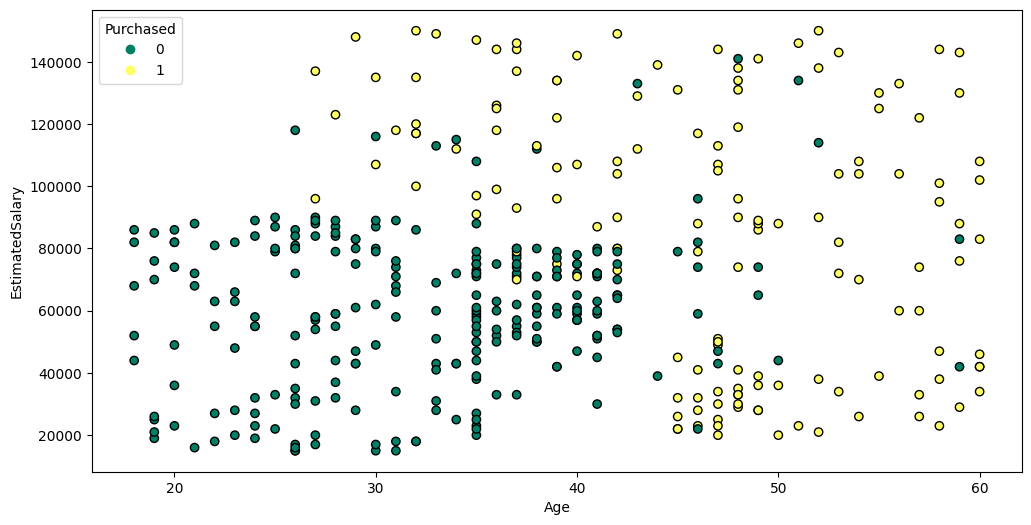

In [178]:
plt.figure(figsize=(12,6))
scatter = plt.scatter(spark_data_raw.toPandas()['Age'], spark_data_raw.toPandas()['EstimatedSalary'], c=spark_data_raw.toPandas()['Purchased'], cmap='summer', edgecolors='black')
plt.xlabel('Age')
plt.ylabel('EstimatedSalary')
plt.legend(*scatter.legend_elements(), title='Purchased')
plt.show()



<font size = "13"><span style="color:#EFE1D1">
(☞ﾟヮﾟ)☞ Data Transformation
</span></font>

In [179]:
spark_data_copy = spark_data_raw.alias('spark_data_copy')

In [180]:
spark_data_copy.show(2)

+--------+------+---+---------------+---------+
| User ID|Gender|Age|EstimatedSalary|Purchased|
+--------+------+---+---------------+---------+
|15624510|  Male| 19|          19000|        0|
|15810944|  Male| 35|          20000|        0|
+--------+------+---+---------------+---------+
only showing top 2 rows



In [181]:
string_indexer = StringIndexer()\
    .setInputCol('Gender')\
    .setOutputCol('genderIndexed')

spark_data_copy = string_indexer.\
    fit(spark_data_copy).\
    transform(spark_data_copy)

spark_data_copy.select('Gender', 'genderIndexed').show()


+------+-------------+
|Gender|genderIndexed|
+------+-------------+
|  Male|          1.0|
|  Male|          1.0|
|Female|          0.0|
|Female|          0.0|
|  Male|          1.0|
|  Male|          1.0|
|Female|          0.0|
|Female|          0.0|
|  Male|          1.0|
|Female|          0.0|
|Female|          0.0|
|Female|          0.0|
|  Male|          1.0|
|  Male|          1.0|
|  Male|          1.0|
|  Male|          1.0|
|  Male|          1.0|
|  Male|          1.0|
|  Male|          1.0|
|Female|          0.0|
+------+-------------+
only showing top 20 rows



In [182]:
one_hot = OneHotEncoder(dropLast=False)\
    .setInputCol('genderIndexed')\
    .setOutputCol('genderEncoded')

spark_data_copy = one_hot.\
    fit(spark_data_copy).\
    transform(spark_data_copy)

spark_data_copy.select('Gender', 'genderIndexed', 'genderEncoded').show()


+------+-------------+-------------+
|Gender|genderIndexed|genderEncoded|
+------+-------------+-------------+
|  Male|          1.0|(2,[1],[1.0])|
|  Male|          1.0|(2,[1],[1.0])|
|Female|          0.0|(2,[0],[1.0])|
|Female|          0.0|(2,[0],[1.0])|
|  Male|          1.0|(2,[1],[1.0])|
|  Male|          1.0|(2,[1],[1.0])|
|Female|          0.0|(2,[0],[1.0])|
|Female|          0.0|(2,[0],[1.0])|
|  Male|          1.0|(2,[1],[1.0])|
|Female|          0.0|(2,[0],[1.0])|
|Female|          0.0|(2,[0],[1.0])|
|Female|          0.0|(2,[0],[1.0])|
|  Male|          1.0|(2,[1],[1.0])|
|  Male|          1.0|(2,[1],[1.0])|
|  Male|          1.0|(2,[1],[1.0])|
|  Male|          1.0|(2,[1],[1.0])|
|  Male|          1.0|(2,[1],[1.0])|
|  Male|          1.0|(2,[1],[1.0])|
|  Male|          1.0|(2,[1],[1.0])|
|Female|          0.0|(2,[0],[1.0])|
+------+-------------+-------------+
only showing top 20 rows



In [183]:
num_assembler = VectorAssembler()\
    .setInputCols(['Age', 'EstimatedSalary'])\
    .setOutputCol('numFeatures')

spark_data_copy = num_assembler.transform(spark_data_copy)

spark_data_copy.select('numFeatures').show(truncate=False)


+---------------+
|numFeatures    |
+---------------+
|[19.0,19000.0] |
|[35.0,20000.0] |
|[26.0,43000.0] |
|[27.0,57000.0] |
|[19.0,76000.0] |
|[27.0,58000.0] |
|[27.0,84000.0] |
|[32.0,150000.0]|
|[25.0,33000.0] |
|[35.0,65000.0] |
|[26.0,80000.0] |
|[26.0,52000.0] |
|[20.0,86000.0] |
|[32.0,18000.0] |
|[18.0,82000.0] |
|[29.0,80000.0] |
|[47.0,25000.0] |
|[45.0,26000.0] |
|[46.0,28000.0] |
|[48.0,29000.0] |
+---------------+
only showing top 20 rows



In [184]:
standardize = MinMaxScaler(min=0, max=1)\
    .setInputCol('numFeatures')\
    .setOutputCol('numFeaturesScaled')

spark_data_copy = standardize\
    .fit(spark_data_copy)\
    .transform(spark_data_copy)

spark_data_copy.select('numFeatures', 'numFeaturesScaled').show(truncate=False)


+---------------+------------------------------------------+
|numFeatures    |numFeaturesScaled                         |
+---------------+------------------------------------------+
|[19.0,19000.0] |[0.023809523809523808,0.02962962962962963]|
|[35.0,20000.0] |[0.40476190476190477,0.037037037037037035]|
|[26.0,43000.0] |[0.19047619047619047,0.2074074074074074]  |
|[27.0,57000.0] |[0.21428571428571427,0.3111111111111111]  |
|[19.0,76000.0] |[0.023809523809523808,0.45185185185185184]|
|[27.0,58000.0] |[0.21428571428571427,0.31851851851851853] |
|[27.0,84000.0] |[0.21428571428571427,0.5111111111111111]  |
|[32.0,150000.0]|[0.3333333333333333,1.0]                  |
|[25.0,33000.0] |[0.16666666666666666,0.13333333333333333] |
|[35.0,65000.0] |[0.40476190476190477,0.37037037037037035] |
|[26.0,80000.0] |[0.19047619047619047,0.4814814814814815]  |
|[26.0,52000.0] |[0.19047619047619047,0.2740740740740741]  |
|[20.0,86000.0] |[0.047619047619047616,0.5259259259259259] |
|[32.0,18000.0] |[0.3333

In [185]:
assembler = VectorAssembler().\
    setInputCols(['numFeaturesScaled', 'genderEncoded'])\
    .setOutputCol('features')

spark_data_copy = assembler.transform(spark_data_copy)
spark_data_copy.select('features').show(truncate=False)


+--------------------------------------------------+
|features                                          |
+--------------------------------------------------+
|[0.023809523809523808,0.02962962962962963,0.0,1.0]|
|[0.40476190476190477,0.037037037037037035,0.0,1.0]|
|[0.19047619047619047,0.2074074074074074,1.0,0.0]  |
|[0.21428571428571427,0.3111111111111111,1.0,0.0]  |
|[0.023809523809523808,0.45185185185185184,0.0,1.0]|
|[0.21428571428571427,0.31851851851851853,0.0,1.0] |
|[0.21428571428571427,0.5111111111111111,1.0,0.0]  |
|[0.3333333333333333,1.0,1.0,0.0]                  |
|[0.16666666666666666,0.13333333333333333,0.0,1.0] |
|[0.40476190476190477,0.37037037037037035,1.0,0.0] |
|[0.19047619047619047,0.4814814814814815,1.0,0.0]  |
|[0.19047619047619047,0.2740740740740741,1.0,0.0]  |
|[0.047619047619047616,0.5259259259259259,0.0,1.0] |
|[0.3333333333333333,0.022222222222222223,0.0,1.0] |
|[0.0,0.4962962962962963,0.0,1.0]                  |
|[0.26190476190476186,0.4814814814814815,0.0,1


<font size = "13"><span style="color:#EFE1D1">
(☞ﾟヮﾟ)☞ Pipeline Building
</span></font>

In [186]:
(train_df,test_df) = spark_data_raw.randomSplit((0.8,0.2))

In [187]:
svm = LinearSVC().setLabelCol('Purchased')\
    .setFeaturesCol('features').setMaxIter(100)\
    .setRegParam(0.1)

stages = [string_indexer, one_hot, num_assembler, standardize, assembler, svm]

pipeline = Pipeline() \
    .setStages(stages)

pipeline_model = pipeline.fit(train_df)



<font size = "13"><span style="color:#EFE1D1">
(☞ﾟヮﾟ)☞ Evaluate on training data
</span></font>

In [188]:
predictions_train = pipeline_model.transform(train_df)
predictions_train.show()

+--------+------+---+---------------+---------+-------------+-------------+---------------+--------------------+--------------------+--------------------+----------+
| User ID|Gender|Age|EstimatedSalary|Purchased|genderIndexed|genderEncoded|    numFeatures|   numFeaturesScaled|            features|       rawPrediction|prediction|
+--------+------+---+---------------+---------+-------------+-------------+---------------+--------------------+--------------------+--------------------+----------+
|15566689|Female| 35|          57000|        0|          1.0|(2,[1],[1.0])| [35.0,57000.0]|[0.40476190476190...|[0.40476190476190...|[1.04482971503912...|       0.0|
|15569641|Female| 58|          95000|        1|          1.0|(2,[1],[1.0])| [58.0,95000.0]|[0.95238095238095...|[0.95238095238095...|[-1.6952912466987...|       1.0|
|15570769|Female| 26|          80000|        0|          1.0|(2,[1],[1.0])| [26.0,80000.0]|[0.19047619047619...|[0.19047619047619...|[1.56839101516540...|       0.0|
|155

In [189]:
evaluator = MulticlassClassificationEvaluator(labelCol='Purchased', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions_train)
print('Accuracy = ', accuracy)
evaluator = MulticlassClassificationEvaluator(labelCol='Purchased', predictionCol='prediction', metricName='f1')
f1_score = evaluator.evaluate(predictions_train)
print('F1 score = ', f1_score)

Accuracy =  0.8201892744479495
F1 score =  0.8132392292839647



<font size = "13"><span style="color:#EFE1D1">
(☞ﾟヮﾟ)☞ Evaluate on training data
</span></font>

In [190]:
predictions_test = pipeline_model.transform(test_df)

In [191]:
evaluator = MulticlassClassificationEvaluator(labelCol='Purchased', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions_test)
print('Accuracy = ', accuracy)
evaluator = MulticlassClassificationEvaluator(labelCol='Purchased', predictionCol='prediction', metricName='f1')
f1_score = evaluator.evaluate(predictions_test)
print('F1 score = ', f1_score)

Accuracy =  0.891566265060241
F1 score =  0.8886081410039133


In [192]:
y_true = predictions_test.select(['Purchased']).collect()
y_pred = predictions_test.select(['prediction']).collect()

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        55
           1       0.91      0.75      0.82        28

    accuracy                           0.89        83
   macro avg       0.90      0.86      0.87        83
weighted avg       0.89      0.89      0.89        83




<font size = "1000"><span style="color:#EFE1D1">
(ﾉ◕ヮ◕)ﾉ*:･ﾟ✧ Thanks for nghe
</span></font>